In [1]:
#Imports
from correlation import getGainAndACamp, get_num_electrons, getFDrive
import numpy, h5py, matplotlib
import matplotlib.pyplot as plt
import glob, os, matplotlib
import scipy.signal as sp
import numpy as np
import bead_util as bu
%matplotlib notebook

In [2]:
def get_pressure_from_name(fname):
    i = fname.rfind('/')
    j = fname.rfind('mbar')
    if j<0:return 0
    else:
        pstr = fname[i+1:j]
        k = pstr.find('_')
        if k<0:return float(pstr)
        else:
            pstr = pstr.replace('_', '.')
            return float(pstr)
def get_pressure(fname, ps):
    p = ps[0]
    true_pressure = max(p, get_pressure_from_name(fname))
    if true_pressure == 0.: true_pressure = 1.E-6
    return true_pressure

In [67]:
def getdata(fname):
    "Opens the data file and turns it into usable data."
    print "Opening file: ", fname
    gain, ACamp = getGainAndACamp(fname, need_ACamp=False)
    f = h5py.File(fname,'r')
    dset = f['beads/data/pos_data']
    dat = numpy.transpose(dset)
    Fs = dset.attrs['Fsamp']
    dat = dat * 10./(2**15 - 1)

    x_dat = dat[:, 0]/gain
    xpsd, freqs = matplotlib.mlab.psd(x_dat-numpy.mean(x_dat), Fs = Fs, NFFT = 2**15) 

    pressure = get_pressure(fname, dset.attrs['temps'])
    
    return freqs, xpsd, pressure

In [68]:
def get_squared_area(f):
    tolerance = 3
    fdrive = getFDrive(f)
    freqs, xpsd, p = getdata(f) # Hz, V/sqrtHz, 1/sqrtHz
    index = np.argmin(np.abs(freqs - fdrive))
    start_index = index - tolerance
    end_index = index + tolerance + 1
    binF = freqs[1]-freqs[0]
    squared_area = binF*sum(xpsd[start_index:end_index]) # V^2
    return squared_area

In [5]:
def plotdata(file_path, calib_path, sphere_diameter):
    """Generates plots from data"""

    file_list = glob.glob(file_path + "/*_att.h5")
    file_list.sort(key=os.path.getmtime)
    fname_1m = file_list[1]
    fname_lp = file_list[-1]
    
    c = getConstant(calib_path, sphere_diameter)
    
    data0 = getdata(fname_lp)
    data1 = getdata(fname_1m)

    plt.figure()
    plt.loglog(data0[0], np.sqrt(data0[1])/c,label="%.1E mbar" % data0[2])
    plt.loglog(data1[0], np.sqrt(data1[1])/c,label="1 mbar")

    matplotlib.rcParams.update({'font.size': 18})

    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Noise Floor [electron/sqrtHz]')
    plt.legend(prop={'size': 16}, loc=3)

    plt.grid()
    plt.show()
    return

In [6]:
# go through 1, 4, 5, and 8
calib1 = "/data/20170726/bead1_15um_QWP/calibration_1positive_47_3Hz/"
path1 = "/data/20170726/bead1_15um_QWP/"
diameter1 = 16.78 # micron

calib4 = "/data/20170726/bead4_15um_QWP/calibration_47_3Hz/"
path4 = "/data/20170726/bead4_15um_QWP/"
diameter4 = 16.18 # micron

calib15 = "/data/20170717/bead15_15um_QWP/calibration/"
path15 = "/data/20170717/bead15_15um_QWP/"
diameter15 = 16.48 # micron (APPROXIMATELY)

calib8 = "/data/20170726/bead8_15um_QWP/calibration_1positive/"
path8 = "/data/20170726/bead8_15um_QWP/"
diameter8 = 16.38 # micron

calibs = [calib1, calib4, calib15, calib8]
paths = [path1, path4, path15, path8]
diameters = [diameter1, diameter4, diameter15, diameter8]

In [ ]:
for file_path, calib_path, sphere_diameter in zip(paths, calibs, diameters):
    plotdata(file_path, calib_path, sphere_diameter)

In [97]:
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

In [145]:
def getConversionArea(calib_path):
    """ normalization to units of electrons """
    calibration_list = bu.time_ordered_file_list(calib_path)

    i = min(len(calibration_list), 3)
    square_areas = []
    for f in calibration_list[:i]:
        square_areas.append(get_squared_area(f))
    area = np.sqrt(np.average(square_areas))

    return area # V

In [187]:
def getConstant(calib_path):
    charge_of_electron = 1.6021766e-19 # m N/V (meter newtons per volt)

    area = getConversionArea(calib_path) # V

    c = area*2.*num_electrons_in_sphere # V/electron

    N = charge_of_electron*80./0.001 # N
    N = area/N # V/N

    return 10.*c, N

In [188]:
file_list = glob.glob(path15 + "/*_att.h5")
file_list.sort(key=os.path.getmtime)
fname_1m = file_list[1]
fname_lp = file_list[-2]

num_electrons_in_sphere = get_num_electrons(diameter15)
c, N = getConstant(calib15) # V/N

data0 = getdata(fname_lp) # Hz, V^2/Hz, mbar
data1 = getdata(fname_1m) # Hz, V^2/Hz, mbar

Opening file:  /data/20170717/bead15_15um_QWP/calibration/auto_xyzcool_G100_att_synth800mV47Hz0mVdc_0.h5
Opening file:  /data/20170717/bead15_15um_QWP/calibration/auto_xyzcool_G100_att_synth800mV47Hz0mVdc_1.h5
Opening file:  /data/20170717/bead15_15um_QWP/calibration/auto_xyzcool_G100_att_synth800mV47Hz0mVdc_2.h5
Opening file:  /data/20170717/bead15_15um_QWP/9E-7mbar_xyzcool_G5_att.h5
Opening file:  /data/20170717/bead15_15um_QWP/1mbar_xyzcool_G5_att.h5


In [189]:
N

55860950489.563515

In [190]:
N/c

0.0025208933695175999

<IPython.core.display.Javascript object>


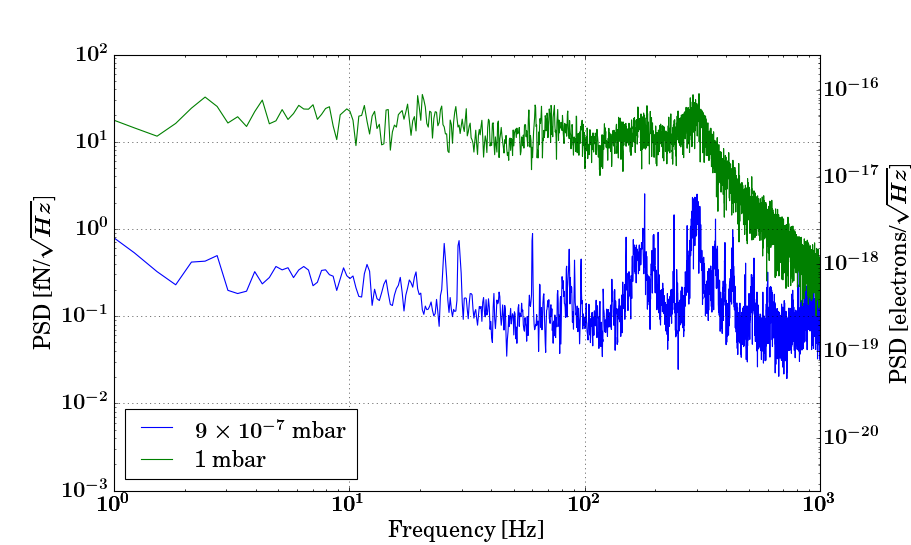

In [207]:
import matplotlib
%matplotlib notebook

psd_fig = plt.figure()

plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']

lplabel = '$'+latex_float(data0[2])+'$ mbar'

lpx = data0[0]
lpy = np.sqrt(data0[1])/N

hpx = data1[0]
hpy = np.sqrt(data1[1])/N


ax1 = psd_fig.add_subplot(111)
ax1.loglog(lpx, lpy*1e15,label=lplabel)
ax1.loglog(hpx, hpy*1e15,label="1 mbar")
plt.xlim([1,1000])
plt.ylabel(r'PSD [fN/\sqrt{\text{Hz}}]', size=20)
ymin, ymax = ax1.get_ylim()
plt.grid()

ax2 = psd_fig.add_subplot(111, sharex=ax1, frameon=False)
ax2.loglog([lpx[0],lpx[-1]], np.array([ymin, ymax])*1e-15*N/c, 'w.')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
plt.ylim(np.array([ymin, ymax])*1e-15*N/c)
plt.ylabel(r'PSD [electrons/\sqrt{\text{Hz}}]', size=20)
#plt.grid()

ax1.legend(prop={'size': 20}, loc=3)
#plt.tight_layout()

plt.xlim([1,1000])
plt.xlabel('Frequency [Hz]')

plt.show()

<IPython.core.display.Javascript object>


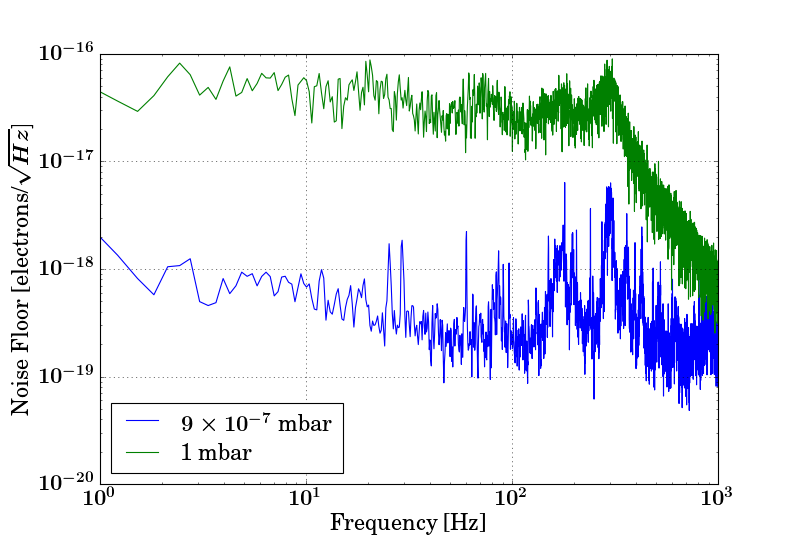

In [175]:
lpx = data0[0]
lpy = np.sqrt(data0[1])/c

hpx = data1[0]
hpy = np.sqrt(data1[1])/c
plt.xlim([1,1000])

plt.loglog(lpx, lpy,label=lplabel)
plt.loglog(hpx, hpy,label="1 mbar")

plt.ylabel(r'Noise Floor [electrons/\sqrt{\text{Hz}}]', size=20)
plt.legend(prop={'size': 20}, loc=3)

plt.xlim([1,1000])
plt.xlabel('Frequency [Hz]')

plt.grid()
plt.show()

<IPython.core.display.Javascript object>


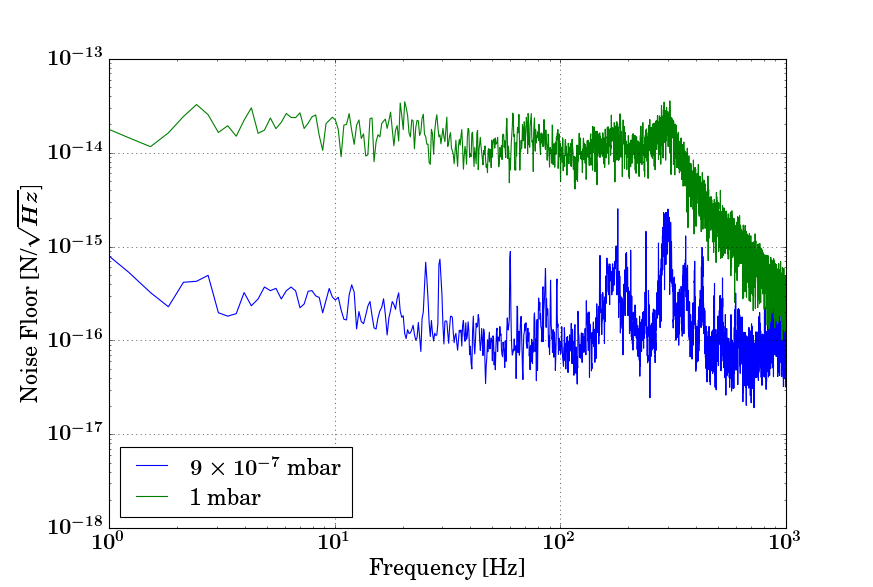

In [176]:
lpx = data0[0]
lpy = np.sqrt(data0[1])/N

hpx = data1[0]
hpy = np.sqrt(data1[1])/N
plt.xlim([1,1000])

plt.loglog(lpx, lpy,label=lplabel)
plt.loglog(hpx, hpy,label="1 mbar")

plt.ylabel(r'Noise Floor [N/\sqrt{\text{Hz}}]', size=20)
plt.legend(prop={'size': 20}, loc=3)

plt.xlim([1,1000])
plt.xlabel('Frequency [Hz]')

plt.grid()
plt.show()

<IPython.core.display.Javascript object>


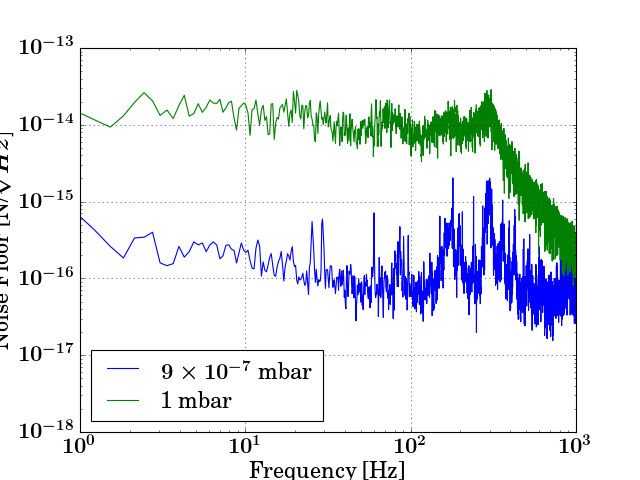

In [177]:
lpx = data0[0]
lpy = (np.sqrt(data0[1])/c)*2e15*1.6e-19*1000./0.001

hpx = data1[0]
hpy = (np.sqrt(data1[1])/c)*2e15*1.6e-19*1000./0.001

plt.xlim([1,1000])

plt.loglog(lpx, lpy,label=lplabel)
plt.loglog(hpx, hpy,label="1 mbar")

plt.ylabel(r'Noise Floor [N/\sqrt{\text{Hz}}]', size=20)
plt.legend(prop={'size': 20}, loc=3)

plt.xlim([1,1000])
plt.xlabel('Frequency [Hz]')

plt.grid()
plt.show()